In [1]:
%load_ext autoreload
%autoreload 2

**<h2> Imports**

In [2]:
import numpy as np
import nibabel as nib

from scipy.ndimage import zoom

import matplotlib.pyplot as plt

<h4>import additional scripts:

In [3]:
import sys

from multiprocessing import Process, Queue
from time import time, sleep

sys.path.insert(1, 'scripts')
from integral_volume import (Point3d, IntegralVol, IntegralVolTest)
from niblack3d import Niblack3d
from multyprocess_utils import MultuProcCalc

<h4> Show efficiency

In [4]:
IntegralVolTest()

preprocess time 0.7668795585632324
numpy time 4.9643003940582275
integral vol time 0.0009853839874267578
calculation error: 3.4924596548080444e-09


**<h2>Load Data**

In [5]:
brain_file = nib.load("data/sub-299_ses-20110422_desc-angio_N4bfc_brain_mask.nii.gz")

brain_vol = np.array(brain_file.dataobj)
print(brain_vol.shape)

(512, 512, 140)


In [6]:
##compressed
#brain_vol = zoom(brain_vol, (0.25, 0.25, 0.5))
#print(brain_vol.shape)

<h4> Padding

In [7]:
new_vol = np.zeros((512, 512, 164))
new_vol[:, :, 12:152] = brain_vol
brain_vol = new_vol

In [8]:
def print_img(vol, axis, title= 'title', slice=None, cmap='hot'):
    global SHOW_SLICE
    axis.set_title(title)
    if slice is None:
        im = axis.imshow(vol[:, :, SHOW_SLICE], cmap=cmap)
    else: 
        im = axis.imshow(vol[:, :, slice], cmap=cmap)
    plt.colorbar(im)

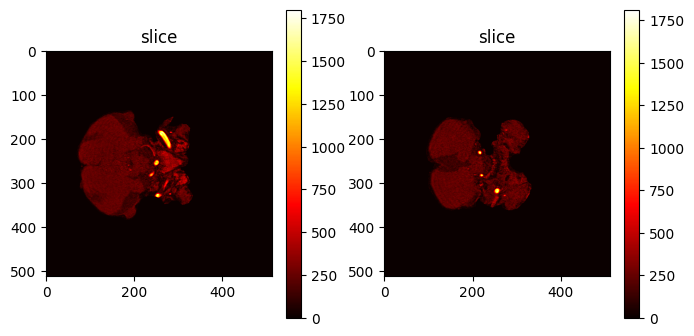

In [9]:
SHOW_SLICE = 31

fig, ax = plt.subplots(1, 2, figsize=(8, 4))    
print_img(brain_vol, ax[0], 'slice', 50)    
print_img(brain_vol, ax[1], 'slice')  

In [14]:
def create_hist(data, bins=100):
    hist = np.histogram(data, bins, range=(data.min(), data.max()))
    counts, bins = hist
    return(counts, bins)

def plot_hist(counts, bins, range, bins_count=None, title="Graph"):
    plt.subplots(figsize=(4, 2)) 
    plt.hist(bins[:-1], bins_count, weights=counts, range=range)
    plt.title(title)
    plt.show()

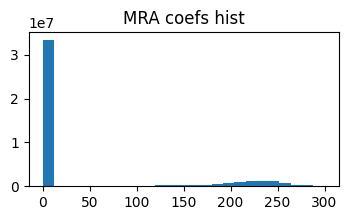

In [15]:
data = brain_vol
counts, bins = create_hist(data, 1000)
plot_hist(counts, bins, (data.min(), 300), 25, "MRA coefs hist")

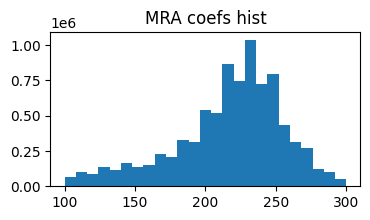

In [16]:
plot_hist(counts, bins, (100, 300), 25, "MRA coefs hist")

**<h2> Binarization**

<h4> Research dispersion

In [17]:
window_size = (25, 25, 9)
coef_k = 1
coef_a = 100
Niblack = Niblack3d(vol=brain_vol,
                    window_size=window_size,
                    coef_k=coef_k, 
                    coef_a=coef_a)

In [18]:
test_edges = [[100, 300],
                [100, 300],
                [50, 100]]
sigmas = Niblack.binarize(edges=test_edges, return_sigma=True)

In [19]:
sigmas = np.array(sigmas)
mu = sigmas[:, 0]
sigma = sigmas[:, 1]

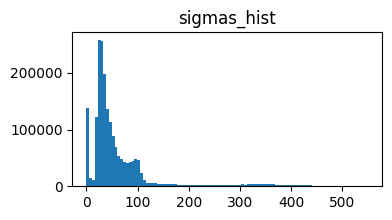

In [21]:
data = sigma
counts, bins = create_hist(data)
plot_hist(counts, bins, (data.min(), data.max()), 100, "sigmas_hist")

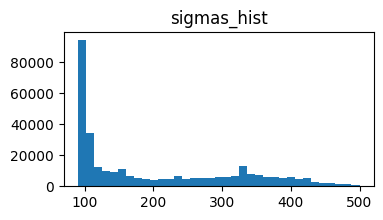

In [22]:
plot_hist(counts, bins, (90, 500), 35, "sigmas_hist")

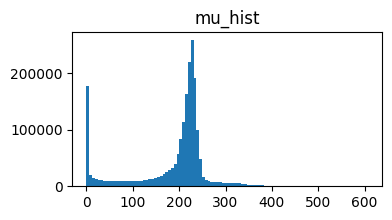

In [23]:
data = mu
counts, bins = create_hist(data)
plot_hist(counts, bins, (data.min(), data.max()), 100, "mu_hist")

In [24]:
mu_agg = mu*1
mu_agg[mu_agg<0.000001] = 0.000001 #cut low mu
one_over_mu = 1/mu_agg 
mu_thresh = 100
one_over_mu[one_over_mu>1/mu_thresh] = 0 #cut low mu
sigma_over_high_mu = sigma * one_over_mu

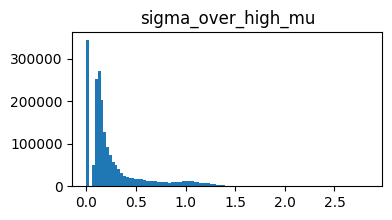

In [29]:
data = sigma_over_high_mu
counts, bins = create_hist(data, 1000)
plot_hist(counts, bins, (data.min(), data.max()), 100, "sigma_over_high_mu")

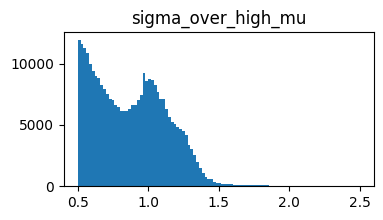

In [36]:
plot_hist(counts, bins, (0.5, 2.5), 100, "sigma_over_high_mu")

<h4> Calculations

In [42]:
window_size = (25, 25, 9)
coef_k = 1
coef_a = 100
Niblack = Niblack3d(vol=brain_vol,
                    window_size=window_size,
                    coef_k=coef_k, 
                    coef_a=coef_a)

Calculator = MultuProcCalc(Niblack, num_workers=8)

In [43]:
start = time()
bin_vol = Calculator.run()
print("spend:", time() - start)

spend: 37.23207879066467


<h4> Сколько тут сосудов?

In [44]:
bin_vol.sum()/(bin_vol.shape[0]*bin_vol.shape[1]*bin_vol.shape[2])

0.002182123137683403

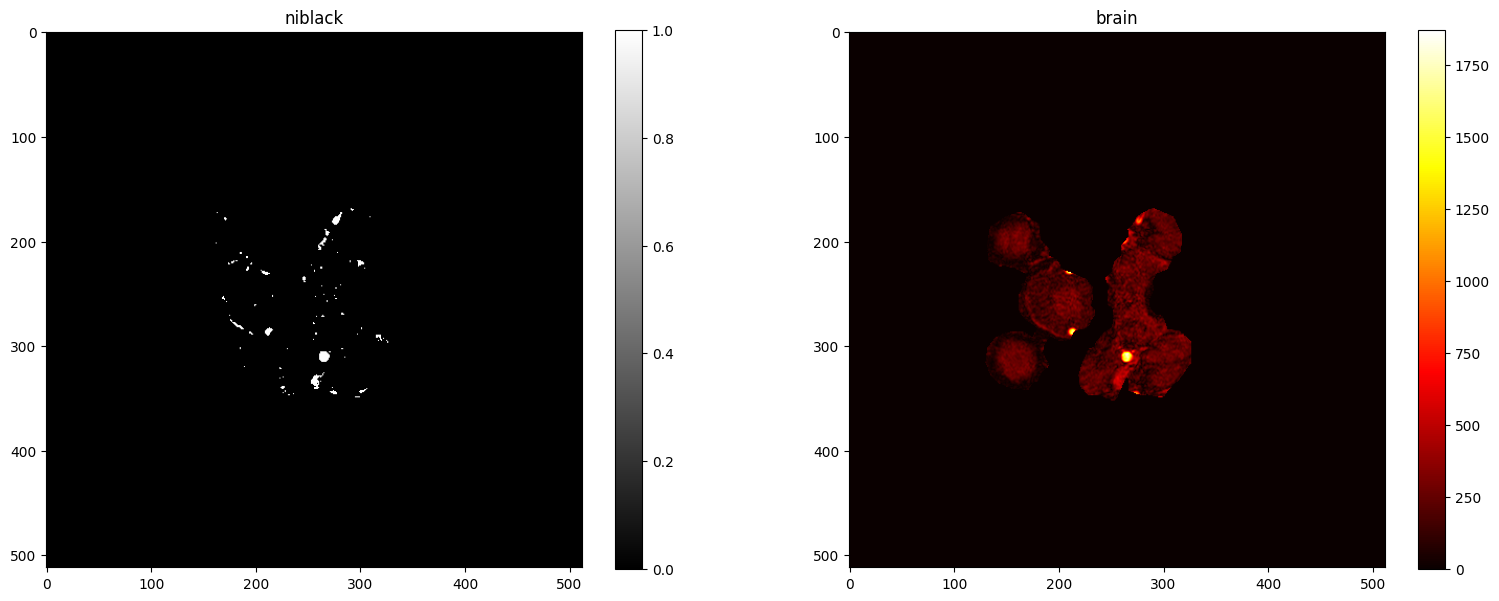

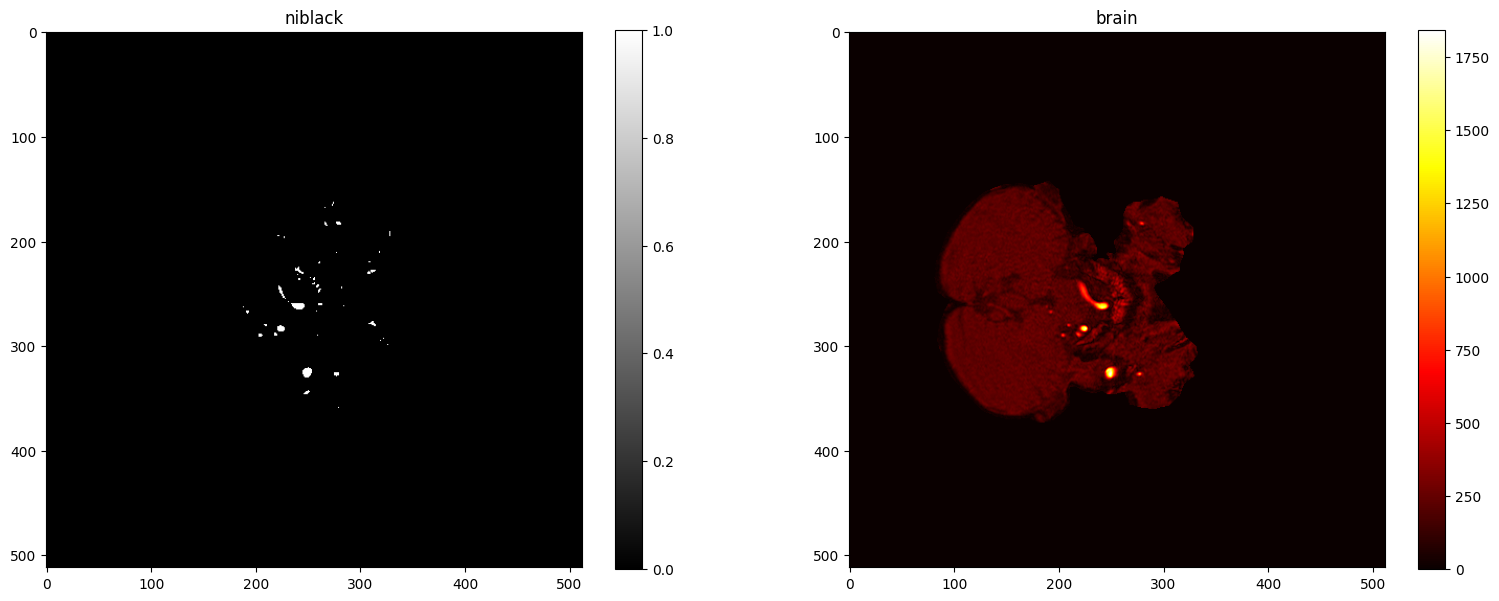

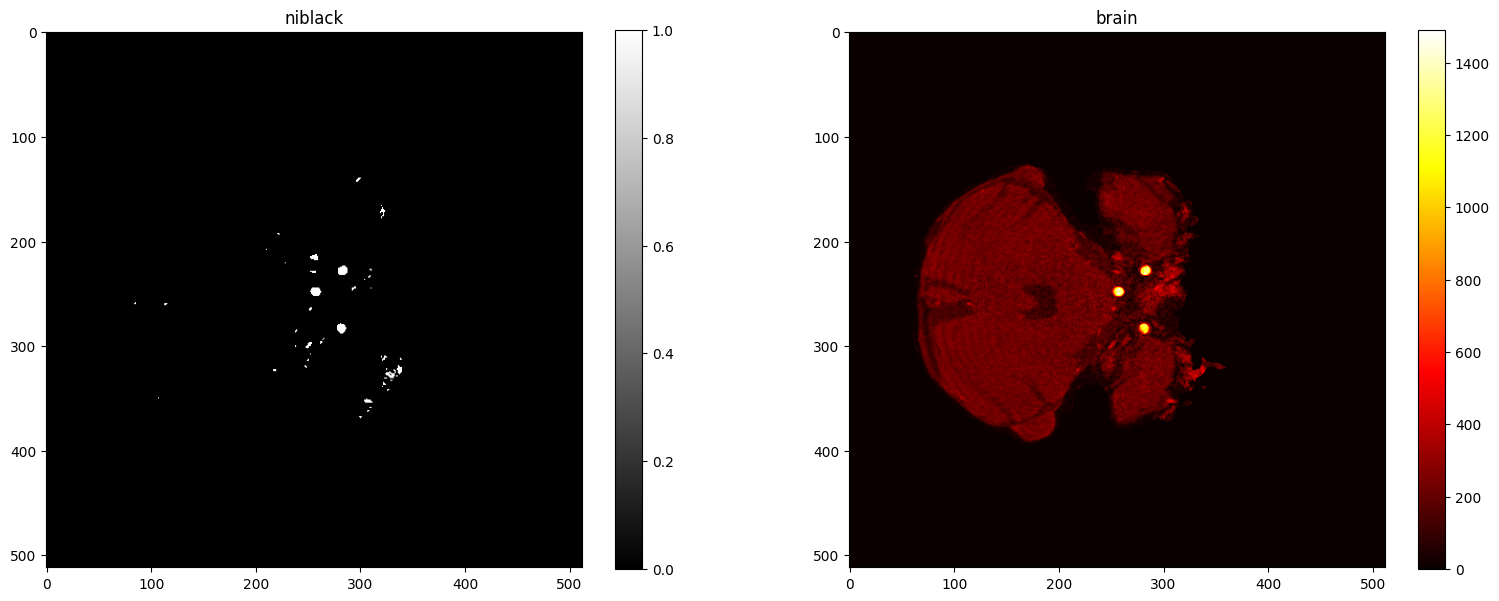

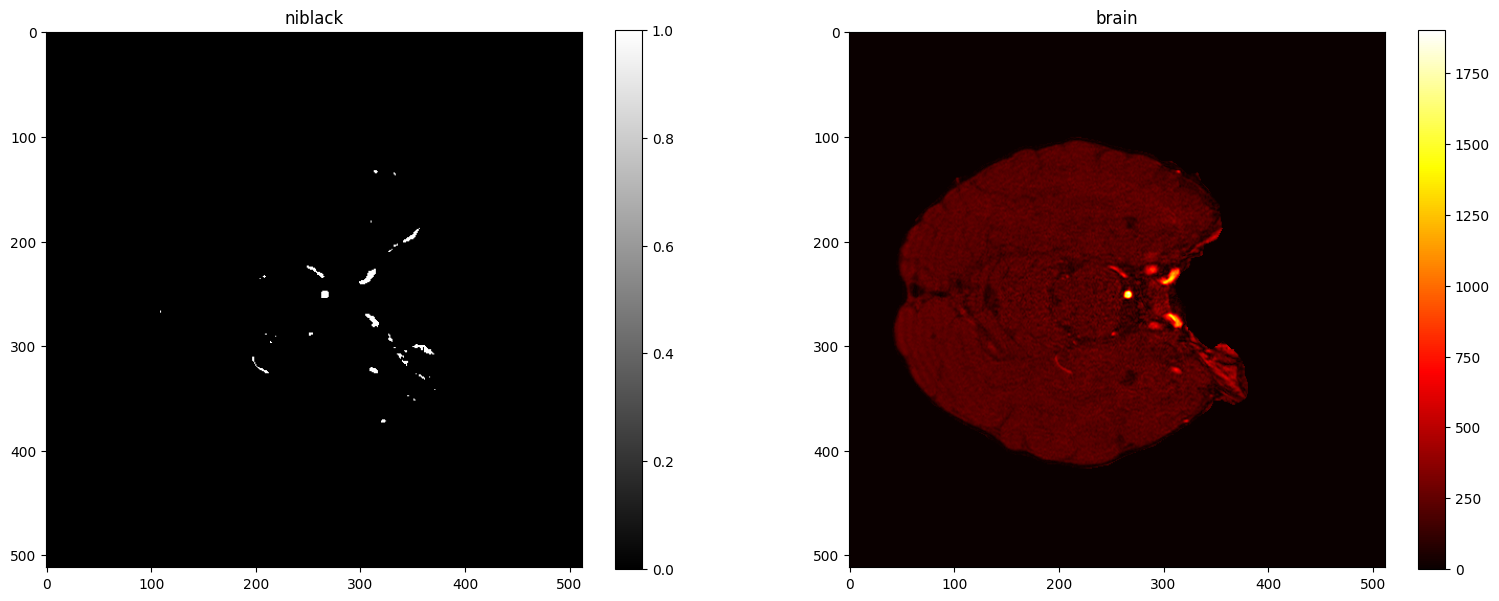

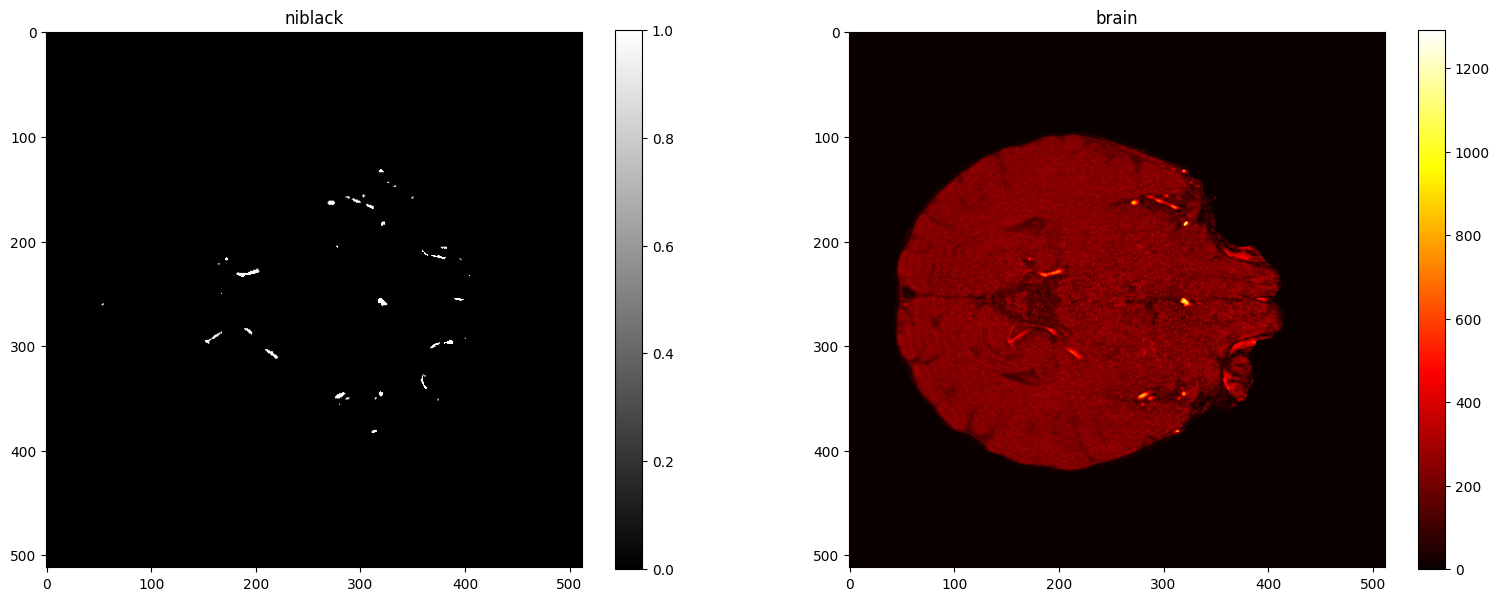

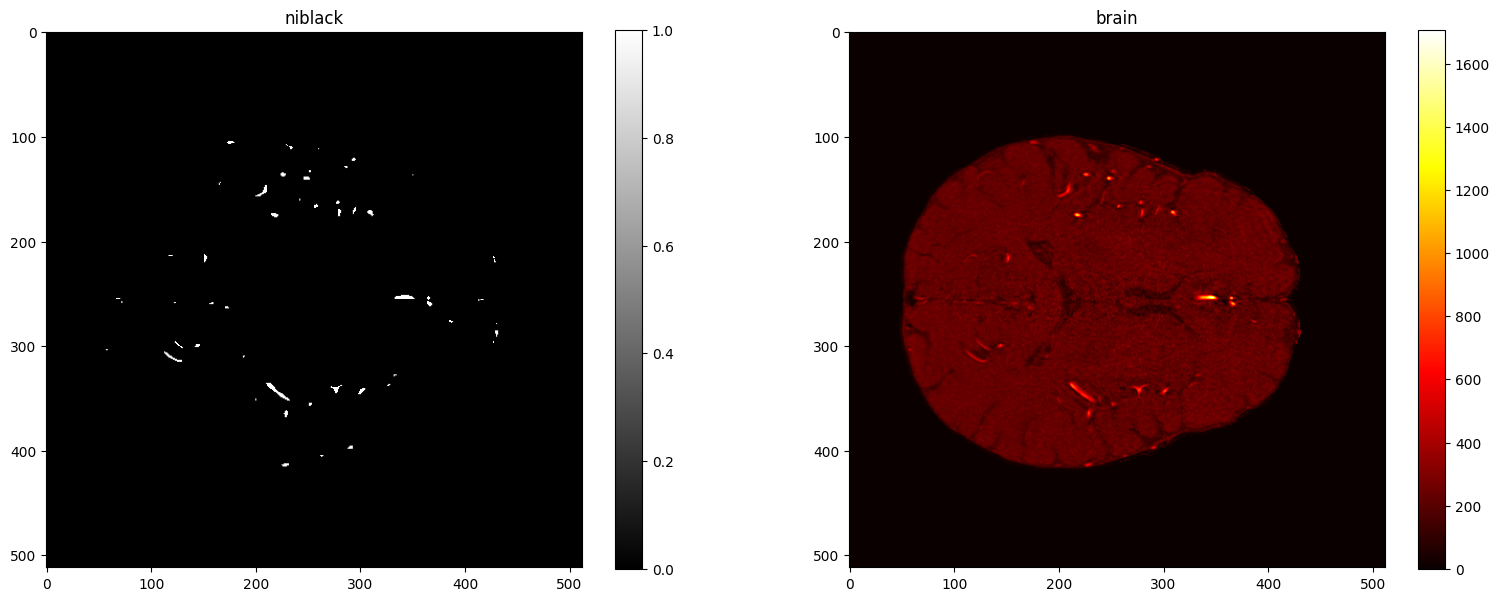

In [46]:
for idx in range(14, 142, 25):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 2, figsize=(19, 7))    
    print_img(bin_vol, ax[0], 'niblack', cmap='gray')    
    print_img(brain_vol, ax[1], 'brain')  

In [54]:
def save_vol_as_nii(numpy_arr, loaded_file, path_to_save):
    empty_header = nib.Nifti1Header()
    Nifti1Image = nib.Nifti1Image(numpy_arr, loaded_file.affine, empty_header)
    nib.save(Nifti1Image, path_to_save)

In [55]:
path_to_save_brain = 'seg_data/brain_vol_compressed1.nii.gz'
path_to_save_seg = 'seg_data/seg_vol_compressed1.nii.gz'

save_vol_as_nii(test_vol, brain_file, path_to_save_brain)
save_vol_as_nii(bin_vol, brain_file, path_to_save_seg)